# Example Preprocessing Notebook

This notebook contains code to apply a set of preprocessing operations on a set of images and pack them into a PINK binary file for training. 

The images used are stored as FITS images on a local disk, with each being a cutout around a position described in a radio source component catalogue. 

The preprocessing operations attempt to:
- estimate a noise level within an image
- apply an island segementation method based on this threshold
- iterate over each island to apply a logarithmic transform and MinMax normalisation

These steps are applied to both the EMU and WISE W1 data. As PINK does not deal with WCS, we also reproject each image so its reference pixel is within the cutout. This avoid distortion effects that are accounted for by the WCS header information, and allows for simpler transformations between on-sky positions and Cartesian positions within a neuron.

In [1]:
import pickle
from multiprocessing import Pool
from glob import glob
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from tqdm import tqdm as tqdm
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from reproject import reproject_interp

import pyink as pu

import logging

logger = logging.getLogger('pyink.binwrap')
logger.addHandler(logging.StreamHandler().setLevel(logging.DEBUG))

np.seterr(all='ignore')

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning, append=True)

These images below were downloaded outside of this notebook. There are many ways to obtain them. For this dataset EMU cutouts were made from a larger image and WISE W1 cutouts were obtained through the `SkyView` service. 

In [2]:
emu = glob('Images_Aegean/*emu.fits')
print(len(emu))
print(emu[0])

249148
Images_Aegean/eb98e110-2aee-4394-ae7d-2beb446633f0_emu.fits


Images were download and saved with a uniqie ID included in the `aegean` component catalogue. Again, there are many different schemes one could use. 

In [3]:
tab = Table.read('../Data/10_field_emu/aegean/aegean_comp.fits').to_pandas()

tab['uuid'] = tab['uuid'].str.decode("utf-8")
tab = tab.set_index('uuid', verify_integrity=True)

tab

,island,source,background,local_rms,ra_str,dec_str,ra,err_ra,dec,err_dec,...,b,err_b,pa,err_pa,flags,residual_mean,residual_std,psf_a,psf_b,psf_pa
uuid,,,,,,,,,,,,,,,,,,,,,
17faf6f9-0d47-4faa-9bc8-c8581dc72f49,1,0,2.735007e-06,0.000063,b'22:16:30.58',b'-63:01:26.45',334.127411,0.000031,-63.024014,0.000008,...,12.015023,0.055042,-61.205288,0.298315,0,-6.266882e-06,0.000074,14.78397,11.051587,-59.004898
e786514c-a154-4c23-bcbe-c13ff45d0935,2,0,-8.031109e-07,0.000061,b'22:15:13.15',b'-63:04:28.70',333.804779,0.000484,-63.074638,0.000108,...,13.088821,1.199520,27.375042,2.564502,0,-3.090008e-06,0.000008,14.78397,11.051587,-59.004898
86eeb9f9-fb3c-4703-8657-1800d758d528,3,0,-2.616467e-06,0.000060,b'22:16:05.38',b'-63:01:14.67',334.022400,0.000115,-63.020741,0.000028,...,13.340526,0.217276,-60.033047,0.843523,0,-5.192538e-06,0.000050,14.78397,11.051587,-59.004898
faaa3d9d-79c3-4fbe-87fc-094bc8419816,4,0,1.788521e-06,0.000062,b'22:17:25.58',b'-62:57:46.30',334.356598,0.000030,-62.962860,0.000009,...,12.138287,0.042448,-59.288612,0.015803,0,-3.987740e-05,0.000311,14.78397,11.051587,-59.004898
34443f11-2d6e-4a38-9cd0-d0a0c305d7d4,5,0,3.743040e-06,0.000062,b'22:17:33.75',b'-62:57:38.63',334.390625,0.000372,-62.960732,0.000088,...,12.368409,0.810359,28.507483,1.088374,0,-1.395770e-06,0.000010,14.78397,11.051587,-59.004898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13f99809-5553-4e21-a80a-d807d66147cb,241146,0,4.826535e-06,0.000075,b'20:40:07.02',b'-48:14:02.38',310.029266,0.000186,-48.233994,0.000052,...,10.497221,0.205064,-60.575142,1.007008,0,-5.707773e-07,0.000015,14.78397,11.051587,-59.004898
b2b53daf-1ebd-4bd3-a42f-dbc302b1da5c,241147,0,-1.538268e-06,0.000068,b'20:47:44.94',b'-48:13:42.58',311.937225,0.000468,-48.228493,0.000106,...,12.575910,0.595964,-60.183002,0.790698,0,-1.184319e-06,0.000010,14.78397,11.051587,-59.004898
4f0fd1db-31c8-4c6c-a115-3700485b98ad,241148,0,-1.310643e-05,0.000070,b'20:43:14.11',b'-48:14:00.87',310.808777,0.000487,-48.233574,0.000228,...,10.671865,1.401948,32.186440,0.322078,0,-1.635617e-05,0.000041,14.78397,11.051587,-59.004898


In [4]:
islands = Counter(tab['island'].values)
tab['n_components'] = tab.apply(lambda x: islands[x['island']], axis=1)

Apply the preprocessing operations for the EMU and WISE images separately. A small set of common preprocessing operations are included in the `pyink` module. This is non-exhaustive, but contain common operations. It is foreseeable that this is expanded in the future, but for the moment the saved steps are sufficent. 

In [5]:
def radio_preprocess(data, lower=3):
    noise = pu.rms_estimate(data.flatten(), mode='mad', clip_rounds=2)
    
    img_scale = np.zeros_like(data)
    for i, mask in enumerate(pu.island_segmentation(data, 3*noise)):
        if np.sum(mask) <= 5:
            continue
        
        img_scale[mask] = pu.minmax(np.log10(data[mask]))
    
    return img_scale.astype(np.float32)

def wise_preprocess(data):
    med = np.median(data.flatten())
    mad = np.median(np.abs(data.flatten() - med))
    
    noise = med + 3*mad
    
    img_scale = np.zeros_like(data)
    for i, mask in enumerate(pu.island_segmentation(data, noise)):
        if np.sum(mask) <= 5:
            continue
        img_scale[mask] = pu.minmax(np.log10(data[mask]))
    
    return img_scale.astype(np.float32)

The `preprocessing` function handles loading the FITS images and applying the appropriate preprocessing operations. Note that some checks are made on the final preprocessed images to ensure:
- There are no `NaN` or `inf` values within an image, which may cause PINK to produce erroneous results
- Images are not completely zero'd out and devoid of features (out of these ~250k images there were two such images)

The `reprojection` steps here are not *strictly* necessary, but are ultimately useful to apply. In subsequent steps on-sky positions (RA/Dec) are projected on the best matching neuron for a particular image. This requires those on-sky positions to be:
- be transformed to pixel-coordinates for that cutout image
- have a spatial transformation applied that is derived by PINK

Both of these operations are much easier to apply if there are no (or very minimumal) distortion effects that would otherwise be handled by the WCS information. Although there is some functionality in the `pyink.CoordinateTransformer` class to use an appropriate WCS object to apply these transformations, it is probably safer to ensure images are on a pixel grid with a local WCS reference frame. It is unclear how PINK would handle the distortion of features while throughout training when the pixel grid is referenced far from the cutout center (imagine a SIN projection for instance). 

In [6]:
def preprocessing(uuid):
    wise = True
    
    emu_src = f"Images_Aegean/{uuid}_emu.fits"
    
    try:
        dlist = fits.open(emu_src)
        d = dlist[0]
    except:
        return None
        
    d_wcs = WCS(d.header).celestial
    d.data = np.squeeze(d.data)
    d.header = d_wcs.to_header()

    reproject_wcs = d.header.copy()
    reproject_wcs['CRVAL1'] = tab.loc[uuid]['ra']
    reproject_wcs['CRVAL2'] = tab.loc[uuid]['dec']
    reproject_wcs['CRPIX1'] = img_size[1] // 2
    reproject_wcs['CRPIX2'] = img_size[2] // 2
    reproject_wcs = WCS(reproject_wcs).celestial

    e_new_data, e_new_footprint = reproject_interp(d, reproject_wcs, shape_out = img_size[1:])

    e_new_data = radio_preprocess(e_new_data)
    dlist.close()
    
    if np.sum(~np.isfinite(e_new_data)) > 0:
        return None
    if np.max(e_new_data) <= 0:
        return None
    
    if wise is False:
        return (uuid, np.array([e_new_data]))
    
    try:
        wlist = fits.open(emu_src.replace('emu','wise'))
        w = wlist[0]
    except:
        return None
    
    
    w_new_data, w_new_footprint = reproject_interp(w, reproject_wcs, shape_out = img_size[1:])
    
    w_new_data = wise_preprocess(w_new_data)
    wlist.close()
    
    if np.sum(~np.isfinite(w_new_data)) > 0:
        return None
    if np.max(w_new_data) <= 0:
        return None
    
    return (uuid, np.array((e_new_data*0.95, w_new_data*0.05)))
    

   The `PINK` binary format is fairly lean, meaning that much of the meta-information about the images can not be stored directly along side the data. There is some functionality to encode information in a `comment header` in this image binary format, but trying to store information in there may be more trouble than it is worth. For the moment, image information is recorded in a separate list that is serialised alongside the file. The index of an image in the binary file is sufficent to retreive the corresponding information from the list object after the fact. If `attributes` are including in `add` for each item then the `ImageWriter` will pickle this as a separate file. 

As the `reproject`ion of the image data can be timeconsuming (even the simplest method applied in this notebook takes about 0.25s per image), a naive speedup is obtained by parallelising the preprocessing across multiple processes. The `runtime` errors below are expected, as some images have `NaN` values.

In [7]:
plt.close()

# interested in `complex` objects
filename = 'PINK_Binaries/Example_PINK_Binary.bin'
emu = tab[tab['n_components'] > 1].index

img_size = (2, 150, 150)

pool = Pool(processes=24)

with pu.ImageWriter(filename, 0, img_size, clobber=True) as pk_img:

    for res in tqdm(pool.imap(preprocessing, emu, chunksize=2), total=len(emu)):
        if res is not None:
            pk_img.add(res[1], attributes=res[0])
            
pool.close()
pool.join()

    

100%|██████████| 22491/22491 [04:42<00:00, 79.48it/s] 


Below are a few sanity checks to make sure the preprocessing went as expected. The `ImageReader` will attempt to find a `pickled` list to read in if one was created with the `ImageWrite`, otherwise one may be specified. 

In [8]:
imgs = pu.ImageReader(filename)

In [9]:
print(imgs.data.shape)
print(imgs.header)
print(len(imgs.records))

(21408, 2, 150, 150)
(2, 0, 0, 21408, 0, 3, (2, 150, 150))
21408


In [10]:
bad = np.sum(~np.isfinite(imgs.data))
print(bad)

0


In [11]:
img_idx = np.arange(0,imgs.data.shape[0])
emu_sum = np.sum(imgs.data[img_idx,0,:,:], axis=1).sum(axis=1)
wise_sum = np.sum(imgs.data[img_idx,1,:,:], axis=1).sum(axis=1)

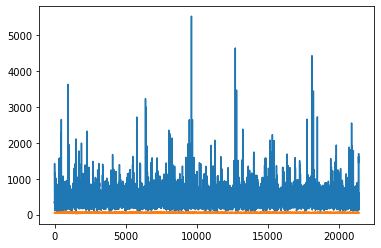

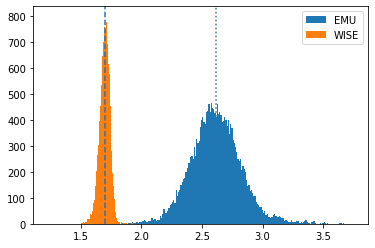

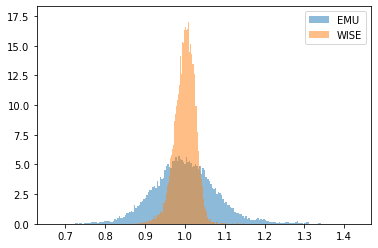

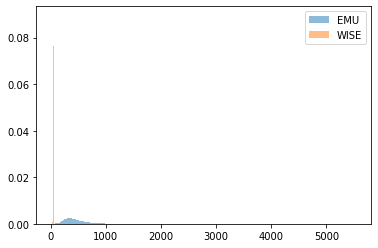

In [12]:
fig, ax = plt.subplots(1,1)

ax.plot(img_idx, emu_sum)
ax.plot(img_idx, wise_sum)

fig, ax = plt.subplots(1,1)

ax.hist(np.log10(emu_sum), bins=200, label='EMU')
ax.hist(np.log10(wise_sum), bins=200, label='WISE')
ax.axvline(np.mean(np.log10(emu_sum)),ls=':')
ax.axvline(np.mean(np.log10(wise_sum)),ls='--')

ax.legend()

fig, ax = plt.subplots(1,1)

ax.hist(np.log10(emu_sum) / np.mean(np.log10(emu_sum)), bins=200, label='EMU', density=True, alpha=0.5)
ax.hist(np.log10(wise_sum) / np.mean(np.log10(wise_sum)), bins=200, label='WISE', density=True, alpha=0.5)

ax.legend()

fig, ax = plt.subplots(1,1)

ax.hist(emu_sum , bins=200, label='EMU', density=True, alpha=0.5)
ax.hist(wise_sum, bins=200, label='WISE', density=True, alpha=0.5)

ax.legend()
